# ReAct Agent Scratch
- 題材
  - How to create a ReAct agent from scratch(https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)

[Prebuilt ReAct Agent](https://langchain-ai.github.io/langgraph/how-tos/#prebuilt-react-agent)の`create_react_agent()`を使用せずに`ReAct Agent`を作成する。


![](./img/react.png)

## パッケージインストール

In [90]:
%pip install -qU langgraph langchain-openai python-dotenv

Note: you may need to restart the kernel to use updated packages.


## 環境変数読み込み

In [91]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-study"

## Statusの定義
`Annotated`で`add_messages`を指定することで、Nodeで生成されたmessageを`messages`に追加する。

- reducer(https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)

In [92]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class Status(TypedDict):
    """The state of the agent."""

    messages: Annotated[Sequence[BaseMessage], add_messages]

## モデルの定義

In [93]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## ツールの用意
`@tool`デコレーションを付与することで各関数が`BaseTool`を継承した`Tool`として扱われる。

- `BaseTool`(https://api.python.langchain.com/en/latest/tools/langchain_core.tools.BaseTool.html)
- `Tools`( https://python.langchain.com/docs/concepts/tools/ )

ここではダミー関数として2つの関数を実装している。
- `get_weather`: 都市の情報を渡すと天気を返す
- `search_restaurant`: 料理名を渡すとおすすめのレストランを返す

In [94]:
from langchain_core.tools import tool

@tool
def get_weather(city: str) -> str:
    """天候に関する情報を取得するツール"""
    
    if city == "東京":
        return "東京の天気は晴れです。"
    elif city == "北海道":
        return "北海道の天気は曇りです。"
    else:
        return "データがありません"

@tool
def search_restaurant(dish: str) -> str:
    """レストランに関する情報を取得するツール"""
    if dish == "ハンバーガー":
        return "マクドナルド。"
    elif dish == "ラーメン":
        return "二郎。"
    else:
        return "データがありません"

tools = [get_weather, search_restaurant]
tools_by_name = {tool.name: tool for tool in tools}   # ツール名とツールのdictを作成

## モデルに対してツールを追加


In [95]:
model = model.bind_tools(tools)

## Model Nodeの定義
- LLMに問い合わせを行うNodeを定義
  - `Tool Calling`: LLMはユーザーからの質問を踏まえて使用すべきツールを選択する(ツールの実行はしない)
  - ユーザーへの回答作成: `Tool Node`で実際にツールを実行した結果(`ToolMessage`に格納)を踏まえて回答を作成する


- `Tool Calling`(`Function Calling`)(https://python.langchain.com/docs/concepts/tool_calling/)
  - OpenAIでは`Function Calling`とも呼ばれる(https://platform.openai.com/docs/guides/function-calling/example-use-cases?api-mode=responses)
  - ユーザーからの質問を踏まえて使用すべきツールを選択する
  - LLMに目標を達成するためのツール選択を行わせる
  - LLMはあくまでツールの情報を踏まえて実行すべきツールとその引数を決めるだけ(実行はしない)

In [96]:
from langchain_core.messages import SystemMessage
from langchain_core.runnables import RunnableConfig

def model_node(state: Status, config: RunnableConfig):
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = model.invoke([system_prompt] + state["messages"], config)

    return {"messages": [response]}

## Tool Nodeの定義
- `Model Node`での`Tool Calling`の結果(`AIMessage`の`tool_calls`に格納)を踏まえてツールを実行する。
  - `Status`の`messages`から最新の`message`(LLMからの回答)を取得
  - `message`に含まれる`tool_calls`を取得し、そこに含まれる`name`と`args`を取得する
  - `BaseTool`の`invoke`メソッドを使用してツールを実行する
  - 実行結果を`ToolMessage`に変換し、`outputs`に追加する
  - `outputs`を`Status`の`messages`に追加する

- `ToolNode()`でも代替可能
  - `ToolNode()`: https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent

In [97]:
import json
from langchain_core.messages import ToolMessage

def tool_node(state: Status):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])  # ツールの実行(BaseToolのinvokeメソッドを使用)
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

## Graphの定義

### Graphの初期化

In [98]:
from langgraph.graph import StateGraph

workflow = StateGraph(Status)

### Nodeの追加

In [99]:
workflow.add_node("model_node", model_node)
workflow.add_node("tool_node", tool_node)

### LLMからの応答に応じて分岐を行うための関数を定義
- LLMからの応答に`tool_calls`が含まれているかどうかを確認し、含まれていれば`continue`、含まれていなければ`end`を返す

In [100]:
from langgraph.graph import END

def should_continue(state: Status):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "tool_node"

### Edgeの追加

In [101]:
from langgraph.graph import START

workflow.add_edge(START, "model_node")

workflow.add_conditional_edges(  # 分岐処理を行うEdgeを追加
    "model_node",  # 始点: model_node
    should_continue,  # should_endの戻り値に応じて次のNodeを決定
    ["tool_node", END]  # 分岐先: tool_node, END
)

workflow.add_edge("tool_node", "model_node")

### Graphのコンパイル

In [102]:
graph = workflow.compile()

## グラフの実行

In [105]:
inputs = {"messages": [("user", "東京でラーメンが食べたいな。天気も心配だ。")]}  # get_weather()とsearch_restaurant()が呼び出される

result=graph.invoke(inputs)

print("=== 全てのメッセージを表示 ===")
for message in result["messages"]:
    print(f"{message.__class__.__name__}: {message}")

print("=== 最終的な回答を表示 ===")
print(result["messages"][-1].content)

=== 全てのメッセージを表示 ===
HumanMessage: content='東京でラーメンが食べたいな。天気も心配だ。' additional_kwargs={} response_metadata={} id='970d973e-d3b1-40bd-9331-0f8a71e8ca1e'
AIMessage: content='' additional_kwargs={'tool_calls': [{'id': 'call_Cj5Kr0PfRp182FAoWNPFwazn', 'function': {'arguments': '{"dish": "ラーメン"}', 'name': 'search_restaurant'}, 'type': 'function'}, {'id': 'call_YVnMJS3iCL8P1BhNsXXPDhb6', 'function': {'arguments': '{"city": "東京"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 116, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BRKLaCnqohoMfeWaYSGZ3FRNFuHK5', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-83032e4d-5e1e-44a

## グラフの描画

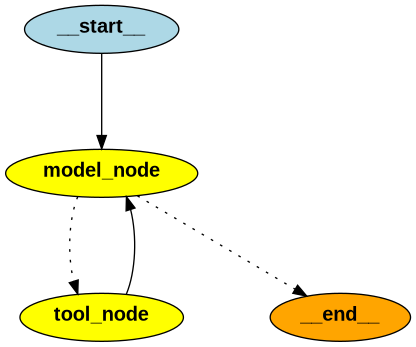

In [104]:
from IPython.display import Image

Image(graph.get_graph().draw_png())